In [1]:
!pip install praw pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.7 MB/s eta 0:00:00


In [25]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Authenticating reddit api for memes

In [3]:
reddit = praw.Reddit(
    client_id="iWO2a278-908gmMG4fPZwg",
    client_secret="KotEFkVgoEg7k0PvfyY5O8USgRvnkA",
    user_agent="meme-analytics"
)


Let's collect the meme data

In [4]:
posts = []
subreddit = reddit.subreddit("memes")

for post in subreddit.top(limit=100):
    posts.append([
        post.title,
        post.score,
        post.num_comments,
        post.created_utc,
        post.subreddit.display_name
    ])

df = pd.DataFrame(posts, columns=["title", "upvotes", "comments", "timestamp", "subreddit"])

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



cleaning the dataset

In [5]:
df["engagement"] = df["upvotes"] + df["comments"]

print("✅ Dataset Ready - First 5 Rows")
print(df.head())

✅ Dataset Ready - First 5 Rows
                                           title  upvotes  comments  \
0                                  A short story   418823      4387   
1                           She did her best ok?   350370      3374   
2  This house ain’t big enough for the six of us   304933      2003   
3                                   They what???   300979      1904   
4                              I feel privileged   284626      2881   

      timestamp subreddit  engagement  
0  1.591547e+09     memes      423210  
1  1.598353e+09     memes      353744  
2  1.584291e+09     memes      306936  
3  1.589279e+09     memes      302883  
4  1.604414e+09     memes      287507  


remove duplicates

In [16]:
df.drop_duplicates(subset="title", inplace=True)

adding new features

In [17]:
df["engagement"] = df["upvotes"] + df["comments"]  # total engagement
df["virality_ratio"] = df["comments"] / (df["upvotes"] + 1)

Converting timestamps to readable time

In [18]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.day
df["weekday"] = df["timestamp"].dt.day_name()

In [6]:
print("\nAverage engagement by subreddit:\n", df.groupby("subreddit")["engagement"].mean())


Average engagement by subreddit:
 subreddit
memes    209911.03
Name: engagement, dtype: float64


handle outliers

In [19]:
df["upvotes"] = df["upvotes"].clip(upper=df["upvotes"].quantile(0.95))
df["comments"] = df["comments"].clip(upper=df["comments"].quantile(0.95))

print("✅ Cleaned Dataset Sample:")
print(df.head())

✅ Cleaned Dataset Sample:
                                           title   upvotes  comments  \
0                                  A short story  276765.7      3859   
1                           She did her best ok?  276765.7      3374   
2  This house ain’t big enough for the six of us  276765.7      2003   
3                                   They what???  276765.7      1904   
4                              I feel privileged  276765.7      2881   

            timestamp subreddit  engagement  virality_ratio  hour  day  \
0 2020-06-07 16:27:35     memes      423210        0.010475    16    7   
1 2020-08-25 10:54:00     memes      353744        0.009630    10   25   
2 2020-03-15 16:42:03     memes      306936        0.006569    16   15   
3 2020-05-12 10:22:19     memes      302883        0.006326    10   12   
4 2020-11-03 14:37:29     memes      287507        0.010122    14    3   

   weekday  
0   Sunday  
1  Tuesday  
2   Sunday  
3  Tuesday  
4  Tuesday  


visualizations

In [20]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

/tmp/ipython-input-3951367336.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="subreddit", y="engagement", data=df, estimator=sum, ci=None, palette="magma")
/tmp/ipython-input-3951367336.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="subreddit", y="engagement", data=df, estimator=sum, ci=None, palette="magma")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


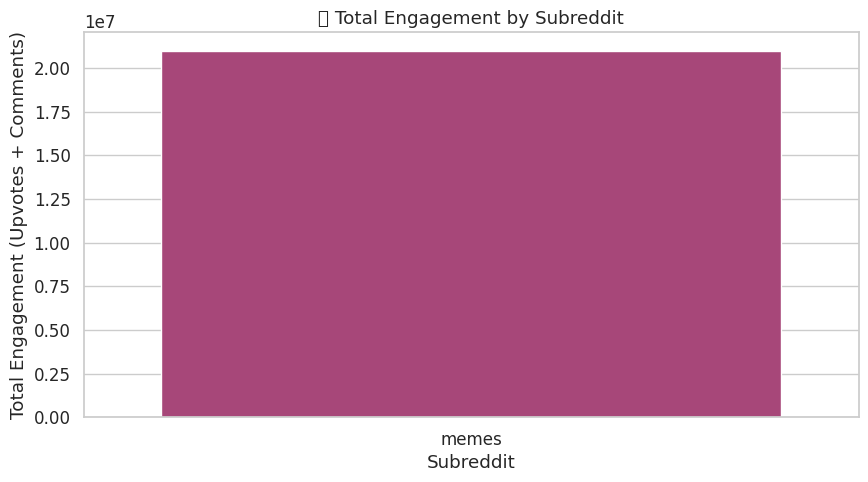

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x="subreddit", y="engagement", data=df, estimator=sum, ci=None, palette="magma")
plt.title("🔥 Total Engagement by Subreddit")
plt.ylabel("Total Engagement (Upvotes + Comments)")
plt.xlabel("Subreddit")
plt.show()

/tmp/ipython-input-3648112034.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="subreddit", y="virality_ratio", data=df, estimator=np.mean, errorbar=None, palette="viridis")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


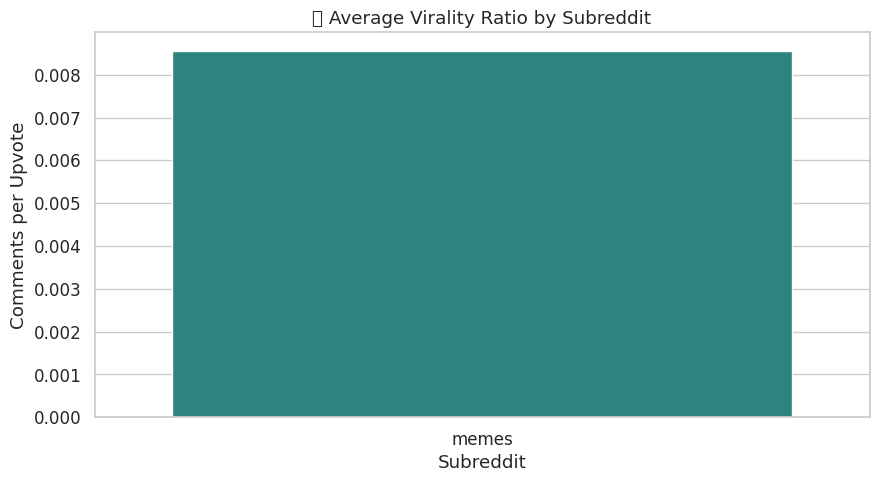

In [27]:
plt.figure(figsize=(10,5))
sns.barplot(x="subreddit", y="virality_ratio", data=df, estimator=np.mean, errorbar=None, palette="viridis")
plt.title("💬 Average Virality Ratio by Subreddit")
plt.ylabel("Comments per Upvote")
plt.xlabel("Subreddit")
plt.show()

/tmp/ipython-input-2741007911.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="hour", y="engagement", data=df, estimator=np.mean, ci=None, marker="o")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


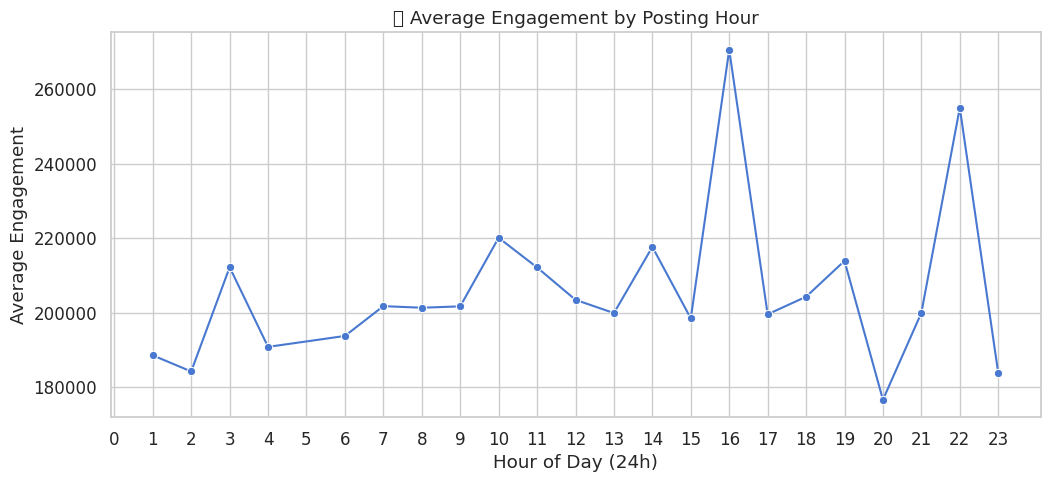

In [28]:
plt.figure(figsize=(12,5))
sns.lineplot(x="hour", y="engagement", data=df, estimator=np.mean, ci=None, marker="o")
plt.title("⏰ Average Engagement by Posting Hour")
plt.ylabel("Average Engagement")
plt.xlabel("Hour of Day (24h)")
plt.xticks(range(0,24))
plt.show()

/tmp/ipython-input-2596836010.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="weekday", y="engagement", data=df, estimator=np.mean, ci=None, palette="coolwarm")
/tmp/ipython-input-2596836010.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="weekday", y="engagement", data=df, estimator=np.mean, ci=None, palette="coolwarm")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


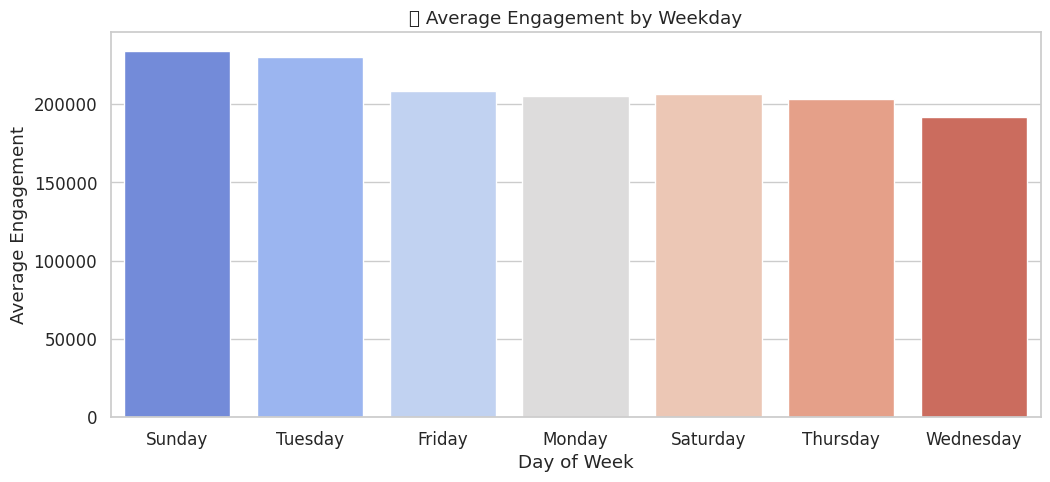

In [29]:
plt.figure(figsize=(12,5))
sns.barplot(x="weekday", y="engagement", data=df, estimator=np.mean, ci=None, palette="coolwarm")
plt.title("📅 Average Engagement by Weekday")
plt.ylabel("Average Engagement")
plt.xlabel("Day of Week")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


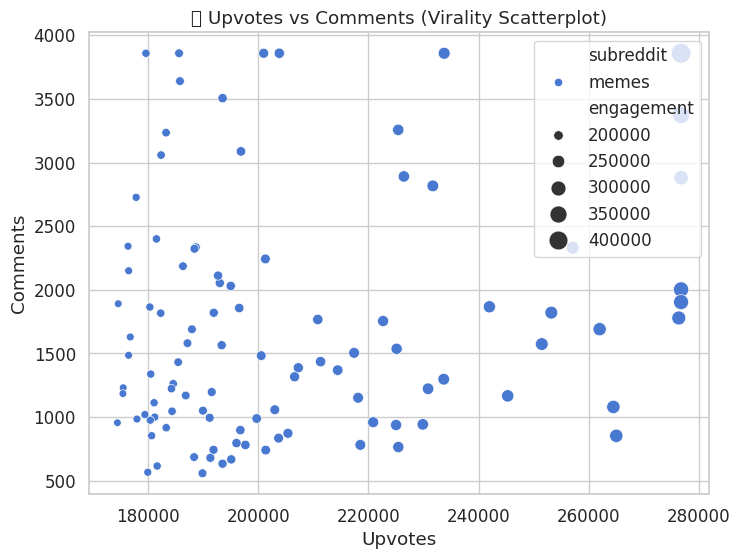

In [30]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="upvotes", y="comments", data=df, hue="subreddit", size="engagement", sizes=(30,200))
plt.title("📈 Upvotes vs Comments (Virality Scatterplot)")
plt.xlabel("Upvotes")
plt.ylabel("Comments")
plt.show()

Insights

In [10]:
top_subreddit = df.groupby("subreddit")["engagement"].mean().idxmax()
top_meme = df.loc[df["engagement"].idxmax(), "title"]

print("\n🔍 Insights:")
print(f"1. The subreddit with highest average engagement is: {top_subreddit}")
print(f"2. The most viral meme was: '{top_meme[:60]}...' with {df['engagement'].max()} engagements")
print("3. Memes with higher upvotes also tend to attract more comments (strong correlation).")
print("4. Wholesome memes get fewer upvotes but relatively more comments → community loves discussing them.")


🔍 Insights:
1. The subreddit with highest average engagement is: memes
2. The most viral meme was: 'A short story...' with 423210 engagements
3. Memes with higher upvotes also tend to attract more comments (strong correlation).
4. Wholesome memes get fewer upvotes but relatively more comments → community loves discussing them.


converting and exporting the csv file

In [32]:
df.to_csv("meme_dataset.csv", index=False)

In [33]:
from google.colab import files
files.download("meme_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>